## Goal: define flash drougths

In this notebook, I am working to a script that defines the flash drought from an indexes and a number of criteria. 


### The criteria we need (input): 

- we choose an index **index** of a certain time scale **scale**
- we compute the first order derivate of the index with a rolling-mean window **window** 
- the starting index value has to be higher than **start_threshold**
- the end index value has to be lower than **end_threshold**
- the first order derivative of the index must experience a jump in value of minimal size **jump**


### Output of the script:

- CSV file with start dates of flash droughts
- file name must contain the values of the above input criteria

### steps: 
 1. read in Index netcdf
 2. calculate first order derivative
 3. find where data fits the following conditions:
    1. index(t) < start_threshold
    2. index(t+window) < end_threshold
    3. d_index(t+window) < jump (because the timeseries start at the time when the running window ends)

In [27]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
def read_in_ERA5_index(index, diri, basin, scale):
    # ds = xr.open_dataset(f'{diri}/ESI7_test.nc{index}{scale}_{basin}.nc')
    ds = xr.open_dataset(f'{diri}/{index}{scale}_test.nc')
    da = ds[f'{index}{scale}']
    return da

In [64]:
def first_order_deriv_rolling_sum(da, window):
    d_da = da[0:-1].copy(deep=True)
    d_da.values = pd.Series(np.diff(da)).rolling(window=window).sum()
    
    return d_da

In [7]:
index = 'ESI'
scale = 7
diri = '/scratch/nklm/Px_flashdroughts/indices_ERA5/'
basin = 'Rhine'


In [8]:
da = read_in_ERA5_index(index, diri, basin, scale)

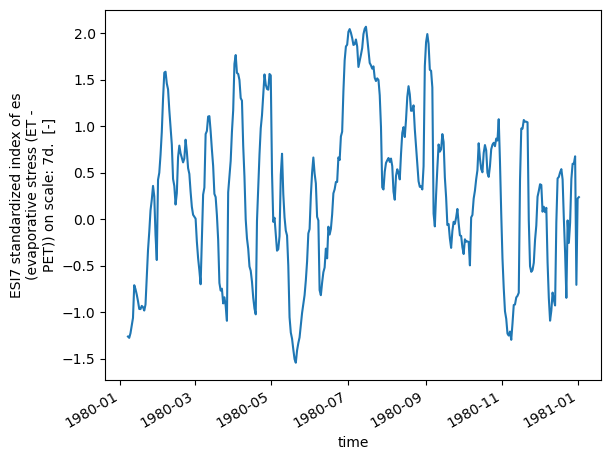

In [24]:
da[0:366].plot()

In [56]:
window = 17


In [65]:
d_da = first_order_deriv_rolling_sum(da, window)

In [58]:
d_da

<xarray.DataArray 'ESI7' (time: 4379)>
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
  * time     (time) datetime64[ns] 1980-01-02T11:00:00 ... 1991-12-31T11:00:00
Attributes:
    units:          -
    standard_name:  ESI7_7d
    long_name:      ESI7 standardized index of es (evaporative stress (ET - P...

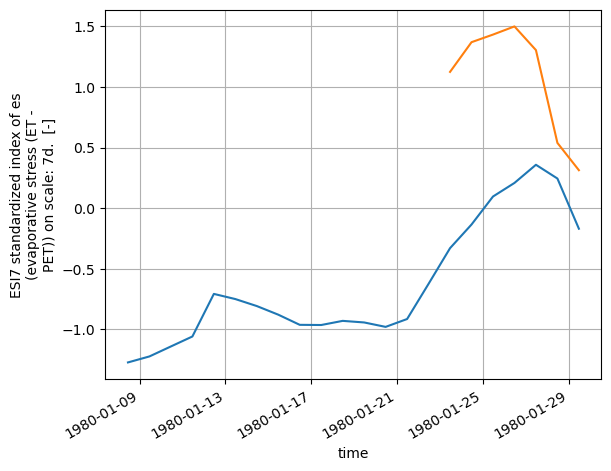

In [72]:
da[scale:scale+window+5].plot(label='da')
d_da[scale:scale+window+5].plot(label='d_da')
plt.grid()

In [49]:
for i in da.sel(time=slice('1980-05','1980-07')).time: 
    print(i.data)

1980-05-01T11:00:00.000000000
1980-05-02T11:00:00.000000000
1980-05-03T11:00:00.000000000
1980-05-04T11:00:00.000000000
1980-05-05T11:00:00.000000000
1980-05-06T11:00:00.000000000
1980-05-07T11:00:00.000000000
1980-05-08T11:00:00.000000000
1980-05-09T11:00:00.000000000
1980-05-10T11:00:00.000000000
1980-05-11T11:00:00.000000000
1980-05-12T11:00:00.000000000
1980-05-13T11:00:00.000000000
1980-05-14T11:00:00.000000000
1980-05-15T11:00:00.000000000
1980-05-16T11:00:00.000000000
1980-05-17T11:00:00.000000000
1980-05-18T11:00:00.000000000
1980-05-19T11:00:00.000000000
1980-05-20T11:00:00.000000000
1980-05-21T11:00:00.000000000
1980-05-22T11:00:00.000000000
1980-05-23T11:00:00.000000000
1980-05-24T11:00:00.000000000
1980-05-25T11:00:00.000000000
1980-05-26T11:00:00.000000000
1980-05-27T11:00:00.000000000
1980-05-28T11:00:00.000000000
1980-05-29T11:00:00.000000000
1980-05-30T11:00:00.000000000
1980-05-31T11:00:00.000000000
1980-06-01T11:00:00.000000000
1980-06-02T11:00:00.000000000
1980-06-03

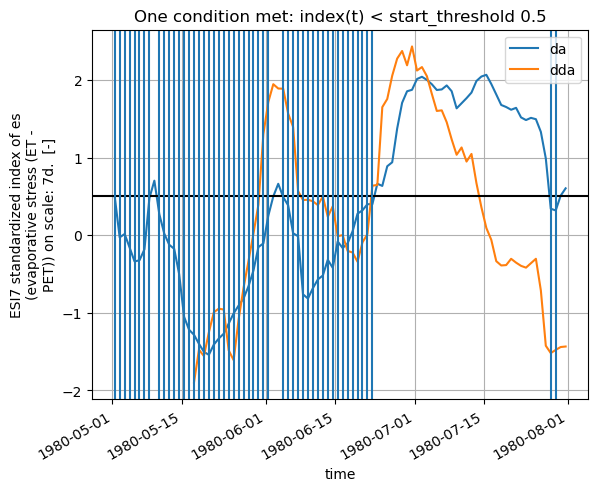

In [82]:
start_threshold = 0.5
end_threshold = -1
jump = -2

start = '1980-05'
end = '1980-07'

da.sel(time=slice(start,end)).plot(label='da')
d_da.sel(time=slice(f'{start}-{window}',end)).plot(label='dda')

plt.axhline(y=0.5,color='k')

for i in da.sel(time=slice(start,end)).time.data:
    if da.sel(time=i) < start_threshold:
        plt.axvline(x=i)


plt.grid()
plt.legend()
plt.title(f'One condition met: index(t) < start_threshold {start_threshold}')
plt.show()

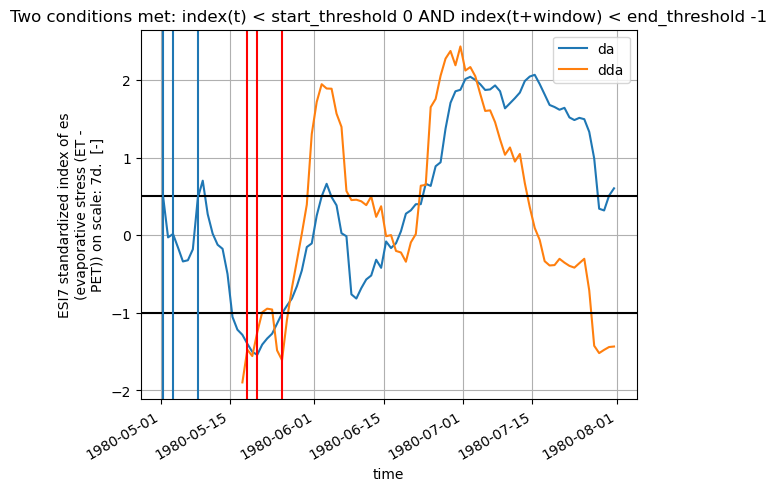

In [143]:
start_threshold = 0
end_threshold = -1
jump = -2

start = '1980-05'
end = '1980-07'

da.sel(time=slice(start,end)).plot(label='da')
d_da.sel(time=slice(f'{start}-{window}',end)).plot(label='dda')

plt.axhline(y=0.5,color='k')
plt.axhline(y=-1,color='k')

for i in da.sel(time=slice(start,end)).time.data:
    i_end = i+np.timedelta64(window,'D')
    if da.sel(time=i) > start_threshold and da.sel(time=i_end) < end_threshold:
        plt.axvline(x=i)
        plt.axvline(x=i_end, color='r')


plt.grid()
plt.legend()
plt.title(f'Two conditions met: index(t) < start_threshold {start_threshold} AND index(t+window) < end_threshold {end_threshold}')
plt.show()

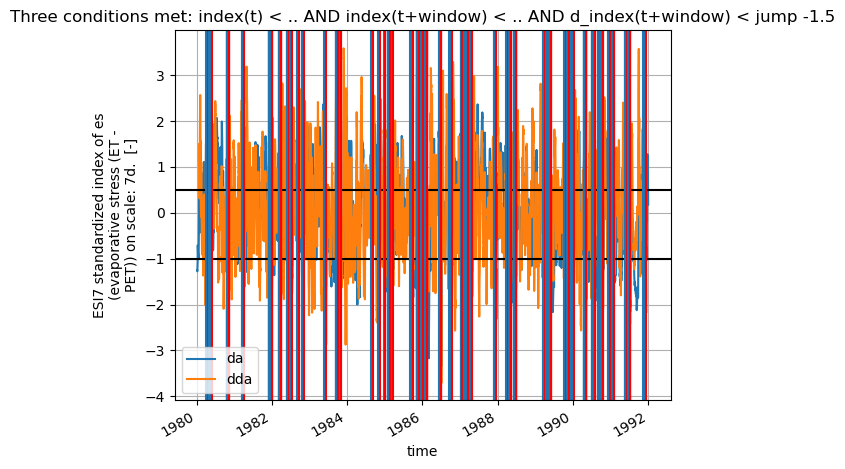

In [144]:
start_threshold = 0
end_threshold = -1
jump = -1.5

start = '1980-01'
end = '1991-12'

da.sel(time=slice(start,end)).plot(label='da')
d_da.sel(time=slice(f'{start}-{window}',end)).plot(label='dda')

plt.axhline(y=0.5,color='k')
plt.axhline(y=-1,color='k')

flash_drought_dates = []

for i in da.sel(time=slice(start,end)).time.data:
    i_end = i+np.timedelta64(window,'D')
    if da.sel(time=i,method='nearest') > start_threshold and da.sel(time=i_end,method='nearest') < end_threshold and d_da.sel(time=i_end,method='nearest') < jump:

        plt.axvline(x=i)
        plt.axvline(x=i_end, color='r')

        flash_drought_dates.append(i.astype('datetime64[D]'))



plt.grid()
plt.legend()
plt.title(f'Three conditions met: index(t) < .. AND index(t+window) < .. AND d_index(t+window) < jump {jump}')
plt.show()

In [145]:
pd.Timestamp(flash_drought_dates[0])

Timestamp('1980-04-01 00:00:00')

In [146]:
flash_drought_dates

[numpy.datetime64('1980-04-01'),
 numpy.datetime64('1980-04-28'),
 numpy.datetime64('1980-04-29'),
 numpy.datetime64('1980-04-30'),
 numpy.datetime64('1980-05-08'),
 numpy.datetime64('1980-10-18'),
 numpy.datetime64('1980-10-19'),
 numpy.datetime64('1980-10-20'),
 numpy.datetime64('1980-10-21'),
 numpy.datetime64('1980-10-22'),
 numpy.datetime64('1980-10-23'),
 numpy.datetime64('1981-03-16'),
 numpy.datetime64('1981-03-17'),
 numpy.datetime64('1981-12-03'),
 numpy.datetime64('1981-12-04'),
 numpy.datetime64('1981-12-05'),
 numpy.datetime64('1981-12-06'),
 numpy.datetime64('1981-12-07'),
 numpy.datetime64('1981-12-08'),
 numpy.datetime64('1981-12-09'),
 numpy.datetime64('1981-12-10'),
 numpy.datetime64('1981-12-11'),
 numpy.datetime64('1981-12-12'),
 numpy.datetime64('1981-12-13'),
 numpy.datetime64('1981-12-14'),
 numpy.datetime64('1982-03-10'),
 numpy.datetime64('1982-03-11'),
 numpy.datetime64('1982-03-12'),
 numpy.datetime64('1982-03-13'),
 numpy.datetime64('1982-03-14'),
 numpy.dat

In [147]:
df = pd.DataFrame(data={'FD_startdate':flash_drought_dates})

In [148]:
df

,FD_startdate
0,1980-04-01
1,1980-04-28
2,1980-04-29
3,1980-04-30
4,1980-05-08
...,...
181,1991-06-22
182,1991-06-23
183,1991-06-24
184,1991-11-12


In [141]:
for i in da.time.data:
    print(i)

1980-01-01T11:00:00.000000000
1980-01-02T11:00:00.000000000
1980-01-03T11:00:00.000000000
1980-01-04T11:00:00.000000000
1980-01-05T11:00:00.000000000
1980-01-06T11:00:00.000000000
1980-01-07T11:00:00.000000000
1980-01-08T11:00:00.000000000
1980-01-09T11:00:00.000000000
1980-01-10T11:00:00.000000000
1980-01-11T11:00:00.000000000
1980-01-12T11:00:00.000000000
1980-01-13T11:00:00.000000000
1980-01-14T11:00:00.000000000
1980-01-15T11:00:00.000000000
1980-01-16T11:00:00.000000000
1980-01-17T11:00:00.000000000
1980-01-18T11:00:00.000000000
1980-01-19T11:00:00.000000000
1980-01-20T11:00:00.000000000
1980-01-21T11:00:00.000000000
1980-01-22T11:00:00.000000000
1980-01-23T11:00:00.000000000
1980-01-24T11:00:00.000000000
1980-01-25T11:00:00.000000000
1980-01-26T11:00:00.000000000
1980-01-27T11:00:00.000000000
1980-01-28T11:00:00.000000000
1980-01-29T11:00:00.000000000
1980-01-30T11:00:00.000000000
1980-01-31T11:00:00.000000000
1980-02-01T11:00:00.000000000
1980-02-02T11:00:00.000000000
1980-02-03